# Active Learning

Active learning is used when we have some sort of scoring function that is too computationally expensive to label the full library of compounds. A machine learning model is trained on a subset of the data and used to score all compounds from within the library. The compounds with the best scores from the ML are labelled using the more expensive function, and the data from this pooled and used to train a new machine learning model. This cycle is repeated until a finish criteria is met. 

Currently this example trains a model to find the compound in the library with the lowerest docking score.

The initial steps in this notebook are:
1. A random sample of the unlabelled data is selected and labelled using the expensive scoring function
2. These labelled datapoints are used to train a simple machine learning (random forest) regressor

Followed the a repeating cycle:

3. The regressor is used to score the entire library
4. The compounds with the highest scores from the machine learning regressor are labelled using the expensive scoring function
5. The labels from the expensive scoring function are pooled and the machine learning model is re-trained

## Imports

In [5]:
import re
import logging
import math
import time
from itertools import product
from pathlib import Path
import gzip
import shutil
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, PandasTools
from rdkit import RDLogger
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

RDLogger.DisableLog("rdApp.*")
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
)

log = logging.getLogger(__name__)

## Defining some useful functions

In [6]:
def dock_mol(mol):
    with Chem.SDWriter("data/docking/tmp_conf.sdf") as w:
        m = Chem.AddHs(mol)
        cids = AllChem.EmbedMultipleConfs(m, numConfs=5, numThreads=0)
        confs = m.GetConformers()
        for c in confs:
            w.write(m, confId=c.GetId())

    subprocess.run(
        [
            "./smina.osx.12",
            "--exhaustiveness",
            "10",
            "--cpu",
            "10",
            "--seed",
            "0",
            "--autobox_ligand",
            "data/docking/ligand_only.pdb",
            "-r",
            "data/docking/protein_minus_ligand.pdb",
            "-l",
            "data/docking/tmp_conf.sdf",
            "-o",
            "data/docking/tmp_conf_docked.sdf.gz",
        ],
        stdout=subprocess.DEVNULL,
    )

    with gzip.open("data/docking/tmp_conf_docked.sdf.gz", "rb") as f_in:
        with open("data/docking/tmp_conf_docked.sdf", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    # The output sdf wasn't loading so this is a workaround
    with open("data/docking/tmp_conf_docked.sdf", "r") as f:
        text = f.read()
    affinities = re.findall(r"<minimizedAffinity>\n(-\d.\d+)", text)
    affinities = [float(x) for x in affinities]
    return min(affinities)

In [7]:
def build_virtual_library() -> pd.DataFrame:
    """Constructs a virtual library by coupling building blocks from the input smi files.

    Returns:
        pd.DataFrame: A DataFrame containing the molecular objects and SMILES strings of the products.
    """
    log.info("Building virtual library")
    try:
        library = pd.read_csv("data/library.csv", index_col="smiles")
        library["mol"] = [Chem.MolFromSmiles(s) for s in tqdm(library.index.to_list())]
    except FileNotFoundError:
        reaction_smarts = "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]"
        bb_types = ["aminobenzoic", "carboxylic_acids", "primary_amines"]
        rxn = AllChem.ReactionFromSmarts(reaction_smarts)

        building_blocks = []
        for bb in bb_types:
            smil = []
            with open(Path(f"data/{bb}_100.smi"), "r") as f:
                for line in f.readlines():
                    smiles, _ = line.split()
                    smil.append(smiles)
            building_blocks.append(smil)

        total_prods = math.prod([len(x) for x in building_blocks])

        product_list = []
        for reagents in tqdm(product(*building_blocks), total=total_prods):
            reagent_mol_list = [Chem.MolFromSmiles(x) for x in reagents]
            products = rxn.RunReactants(reagent_mol_list)
            if products:
                Chem.SanitizeMol(products[0][0])
                product_list.append(products[0][0])
        library = pd.DataFrame(
            product_list,
            index=[Chem.MolToSmiles(m) for m in product_list],
            columns=["mol"],
        )
        library.index.name = "smiles"
        library["slow_scores"] = np.NaN
        library["model_scores"] = np.NaN
        PandasTools.AddMurckoToFrame(library, molCol="mol", MurckoCol="scaffold")
        library.to_csv("data/library.csv")
    log.info("Virtual library built with %s products", len(library))
    return library


def slow_function(mols: pd.Series) -> np.array:
    """The slow scoring function. This function takes too long to score the entire library.

    Args:
        mols (pd.Series): The input molecules.

    Returns:
        np.arary: The scores of the molecules.
    """
    log.info("Scoring %s compounds with slow scoring function", len(mols))
    return np.array([dock_mol(mol) for mol in tqdm(mols)])


def create_morgan_fingerprints(library: pd.DataFrame) -> pd.DataFrame:
    """Creates Morgan fingerprints for the input library.

    Args:
        library (pd.DataFrame): The input library.

    Returns:
        pd.DataFrame: The Morgan fingerprints of the input library.
    """
    log.info("Creating Morgan fingerprints")
    try:
        fps_df = pd.read_csv("data/fingerprints.csv").set_index("smiles")
        fps_df.fillna("", inplace=True)
    except FileNotFoundError:
        fps = [
            list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2))
            for mol in tqdm(library.mol)
        ]
        fps_df = pd.DataFrame(
            fps, columns=[f"fp_{x}" for x in range(len(fps[0]))], index=library.index
        )
        fps_df.to_csv("data/fingerprints.csv")
    return fps_df


def train_ml_model(
    library: pd.DataFrame, fingerprints: pd.DataFrame
) -> RandomForestRegressor:
    """Trains a random forest regressor model on slow scores for the input library.

    Args:
        library (pd.DataFrame): The input library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        RandomForestRegressor: The trained random forest regressor model.
    """
    log.info("Training model with slow scores")
    scored = library[~library["slow_scores"].isna()]
    X = fingerprints.loc[scored.index]
    y = scored["slow_scores"]
    regressor = RandomForestRegressor()
    regressor.fit(X, y)
    return regressor


def score_compounds(X: pd.DataFrame, regressor: RandomForestRegressor) -> np.array:
    """Scores the input compounds with the trained models.

    Args:
        X (pd.DataFrame): The input compounds.
        regressors (list[RandomForestRegressor]): The trained random forest regressor models.

    Returns:
        np.array: The input compounds with the model scores.
    """
    return regressor.predict(X)


def score_library(
    library: pd.DataFrame,
    regressor: RandomForestRegressor,
    fingerprints: pd.DataFrame,
) -> pd.DataFrame:
    """Scores the entire library with the trained model.

    Args:
        library (pd.DataFrame): The input library.
        regressor (RandomForestRegressor): The trained random forest regressor model.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        pd.DataFrame: The input library with the model scores.
    """
    log.info("Scoring entire library with model")
    library["model_scores"] = score_compounds(fingerprints, regressor)
    return library

## Active learning pipeline

In [8]:
def run_active_learning(
    library: pd.DataFrame,
    fingerprints: pd.DataFrame,
    compounds_per_round: int,
    number_of_rounds: int,
    minimize: bool,
) -> tuple[float, float, float]:
    """Runs active learning on the virtual library.

    Args:
        library (pd.DataFrame): The input virtual library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.
        compounds_per_round (int): Number of compounds to select per round.
        number_of_rounds (int): Number of active learning rounds.
        minimize (bool): Whether to minimize or maximize the slow scoring function.

    Returns:
        tuple[float, float, float]: The true best score, the active learning best score,
        and the random sample best score.
    """
    # Select initial random sample
    start = time.time()
    initial_sample = library.sample(compounds_per_round)
    library["slow_scores"] = np.NaN

    # Score the initial sample
    initial_scores = slow_function(initial_sample.mol)

    # Save the slow scores
    library.loc[initial_sample.index, "slow_scores"] = initial_scores

    # Run active learning
    for al_round in range(number_of_rounds):
        log.info("Active learning round %s", al_round + 1)

        # Train the ML model
        model = train_ml_model(library, fingerprints)

        # Use the model to score the entire virtual library
        library = score_library(library, model, fingerprints)

        # Select the top scoring molecules with no slow scores
        top_compounds = (
            library[library["slow_scores"].isna()]
            .sort_values("slow_scores", ascending=minimize)
            .head(compounds_per_round)
        )

        # Score the top molecules with the slow function
        slow_scores = slow_function(top_compounds.mol)

        # Save the slow scores
        library.loc[top_compounds.index, "slow_scores"] = slow_scores
        if MINIMIZE:
            log.info("Current best score: %.2f", library.slow_scores.min())
        else:
            log.info("Current best score: %.2f", library.slow_scores.max())

    end = time.time()
    log.info("Active learning took %.1f seconds", end - start)

    if MINIMIZE:
        return library.slow_scores.min()
    else:
        return library.slow_scores.max()


# Active learning parameters
COMPOUNDS_PER_ROUND = 5
NUMBER_OF_ROUNDS = 5
MINIMIZE = True

# Create the virtual library
library = build_virtual_library()

# Create morgan fingerprints for the library
fingerprints = create_morgan_fingerprints(library)

al_best = run_active_learning(
    library, fingerprints, COMPOUNDS_PER_ROUND, NUMBER_OF_ROUNDS, MINIMIZE
)

start = time.time()
random_scores = slow_function(
    library.sample(COMPOUNDS_PER_ROUND * NUMBER_OF_ROUNDS).mol
)
random_best = min(random_scores) if MINIMIZE else max(random_scores)
end = time.time()

log.info(
    "Scoring random sample with slow scoring function took %.1f seconds", end - start
)

percent_scores = COMPOUNDS_PER_ROUND * NUMBER_OF_ROUNDS / len(library) * 100
log.info(
    f"When scoring {percent_scores:.2f}% of the library: AL best: {al_best:.2f}, Random sample best: {random_best:.2f}"
)
log.info(
    "Estimated time to dock entire library %.2f days",
    (end - start) / 25 * 135000 / 3600 / 24,
)

[2024-02-15 20:16:28,599] INFO: Building virtual library
100%|██████████| 132500/132500 [00:09<00:00, 13692.62it/s]
[2024-02-15 20:16:38,579] INFO: Virtual library built with 132500 products
[2024-02-15 20:16:38,579] INFO: Creating Morgan fingerprints
[2024-02-15 20:16:47,654] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [04:40<00:00, 56.07s/it]
[2024-02-15 20:21:27,999] INFO: Active learning round 1
[2024-02-15 20:21:28,000] INFO: Training model with slow scores
[2024-02-15 20:21:28,084] INFO: Scoring entire library with model
[2024-02-15 20:21:28,601] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [05:53<00:00, 70.76s/it]
[2024-02-15 20:27:22,413] INFO: Current best score: -9.27
[2024-02-15 20:27:22,414] INFO: Active learning round 2
[2024-02-15 20:27:22,414] INFO: Training model with slow scores
[2024-02-15 20:27:22,483] INFO: Scoring entire library with model
[2024-02-15 20:27:22,924] INFO: Scoring 5 compounds with slow scorin

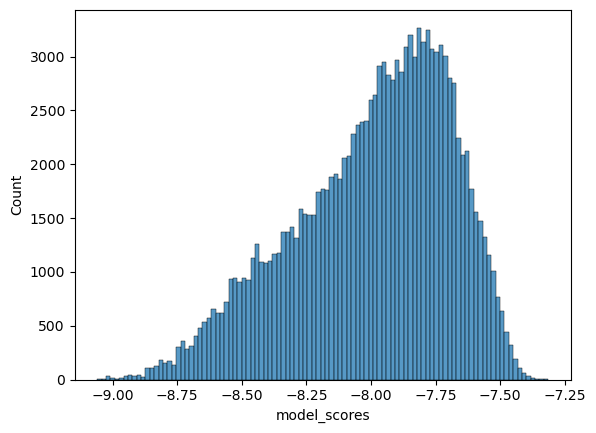

In [40]:
sns.histplot(library.model_scores)
plt.show()